### Big Data CS696 - Assignment 3 - Somnath Shantveer (RedId - 823379096)

In [2]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pyspark.sql as sql
from pyspark.sql.functions import mean as mean, stddev as stddev, asc as asc

gpa_gre_data_file = 'gpa-gre.csv'
dwell_data_file = 'dwell_data/multiple-sites.tsv'

### Problem 1. 
The dataset GPA-GRE contains 16 years of GPA, Verbal and Quantitative GRE
scores for graduate students.

a. Use linear regression with the combined GRE score (Verbal + Quantitive) as the independent
variable and the GPA as the dependent variable to create a model that predicts a students
GPA given their combined GRE score.

b. What is the r2 score of the model?

c. Plot the residuals of the data from the model.

R2 (Variance) score using linear_model =  0.08562617249013671
R2 (Variance) score using sklearn metrics =  0.08593938369324272


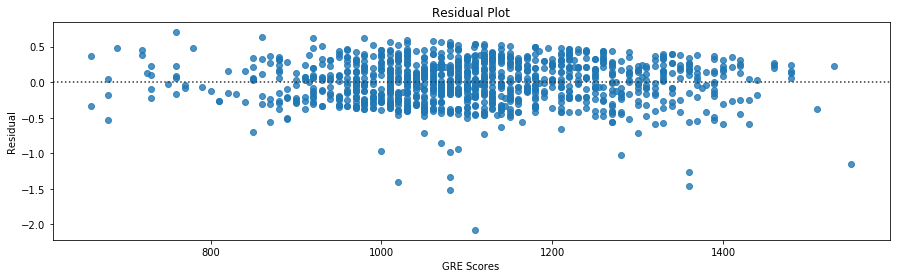

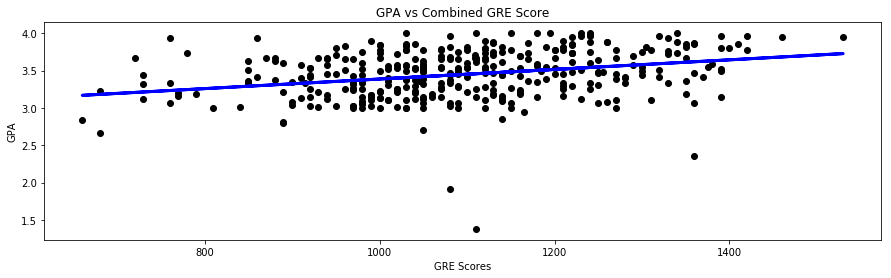

In [3]:
gpa_gre_data = pd.read_csv(gpa_gre_data_file)

# Combine verbal and Quant scores into combined_score.
gpa_gre_data['combined_score'] = gpa_gre_data.apply(lambda x: x['Verbal'] + x['Quant'], axis=1)

# Fill null values with mean
gpa_gre_data['combined_score'] = gpa_gre_data['combined_score'].fillna(gpa_gre_data['combined_score'].mean())

gre_score = gpa_gre_data.combined_score.values.reshape(-1, 1)
gpa = gpa_gre_data.GPA.values

#Split data in train and test
gre_score_train, gre_score_test, gpa_train, gpa_test = train_test_split(gre_score, gpa, test_size=0.33, random_state=42)

# Train the model
linear_regression_model = LinearRegression()
linear_regression_model.fit(gre_score_train, gpa_train)

# Calculate the r2_score (variance score) using sklearn linear_model.
r2_score_1 = linear_regression_model.score(gre_score, gpa)
print('R2 (Variance) score using linear_model = ', r2_score_1)

# Predict gpa with the trained model using test data.
gpa_predicted = linear_regression_model.predict(gre_score_test)

# r2_score using sklearn metrics (1 is perfect prediction)
r2_score_2 = r2_score(gpa_test, gpa_predicted)
print('R2 (Variance) score using sklearn metrics = ', r2_score_2)


# Plot residuals of the data using seaborn residplot
plt.figure(figsize=(15,4))
sb.residplot(gre_score, gpa)
plt.xlabel("GRE Scores")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

# Plot actual vs predicted GPA from the model
plt.figure(figsize=(15,4))
plt.scatter(gre_score_test, gpa_test,  color='black')
plt.plot(gre_score_test, gpa_predicted, color='blue', linewidth=3)
plt.xlabel("GRE Scores")
plt.ylabel("GPA")
plt.title("GPA vs Combined GRE Score")
plt.show()

### Problem 2. 
In the dataset dwell data there is a file multiple-site.tsv.

The file contains two columns: a site number and dwell-time on that site. Each site contains multiple entires.

Using scikitlearn compute the mean and standard deviation of the dwell time per site.

In [4]:
####### Using Panda ##########
dwell_time_panda = pd.read_csv(dwell_data_file, sep='\t')

grouped_dwell_time = dwell_time_panda.groupby(['site'], as_index=False)

mean_panda = grouped_dwell_time.mean()
stddev_panda = grouped_dwell_time['dwell-time'].apply(lambda x: x.std())

print("Mean of dwell time per site using panda")
print(mean_panda)
print("Stddev of dwell time per site using panda")
print(stddev_panda)

Mean of dwell time per site using panda
    site  dwell-time
0      0   79.851064
1      1  106.000000
2      2   88.229167
3      3   97.479167
4      4   94.333333
5      5  102.333333
6      6  144.192982
7      7  123.367347
8      8   94.346939
9      9   89.820000
10    10  129.952381
11    11   96.982143
12    12   80.950820
13    13   90.737705
14    14   74.764706
15    15  119.347826
16    16   86.744186
17    17   77.891304
18    18   94.814815
19    19   89.280702
Stddev of dwell time per site using panda
0      79.135266
1     103.790126
2      88.709001
3      74.814093
4      77.725843
5      87.700618
6     146.930917
7     117.025584
8      97.564626
9     100.470463
10     90.109406
11     78.946355
12     68.987300
13    102.013872
14     78.262785
15    107.020500
16    118.835239
17     83.413889
18     81.657609
19     93.710564
dtype: float64


Using Spark (not scikitlearn) compute the mean and standard deviation of the dwell time per site.

In [5]:
####### Using Spark ##########
spark = sql.SparkSession.builder.master("local")\
        .appName("Assignment 3 spark session")\
        .getOrCreate()

df = spark.read\
    .option("header", "true")\
    .option("sep", "\t")\
    .csv(dwell_data_file)

print(df.head(5))

mean_result = df.groupBy('site').agg(mean('dwell-time')).orderBy(asc('site'))
stddev_result = df.groupBy('site').agg(stddev('dwell-time')).orderBy(asc('site'))

print("Mean of dwell time per site using spark")
mean_result.show()
print("Stddev of dwell time per site using spark")
stddev_result.show()

[Row(site='13', dwell-time='28'), Row(site='6', dwell-time='33'), Row(site='17', dwell-time='81'), Row(site='1', dwell-time='67'), Row(site='16', dwell-time='87')]
Mean of dwell time per site using spark
+----+------------------+
|site|   avg(dwell-time)|
+----+------------------+
|   0| 79.85106382978724|
|   1|             106.0|
|  10|129.95238095238096|
|  11| 96.98214285714286|
|  12| 80.95081967213115|
|  13| 90.73770491803279|
|  14| 74.76470588235294|
|  15|119.34782608695652|
|  16| 86.74418604651163|
|  17|  77.8913043478261|
|  18| 94.81481481481481|
|  19| 89.28070175438596|
|   2| 88.22916666666667|
|   3| 97.47916666666667|
|   4| 94.33333333333333|
|   5|102.33333333333333|
|   6|144.19298245614036|
|   7|123.36734693877551|
|   8| 94.34693877551021|
|   9|             89.82|
+----+------------------+

Stddev of dwell time per site using spark
+----+-----------------------+
|site|stddev_samp(dwell-time)|
+----+-----------------------+
|   0|      79.13526634363751|
|   1